# Table Of Content:
* Preliminaries
    * [Before starting the lab !](#lab0)
    * [Structure of the lab](#structure)
    * [Objective of the lab](#objective)
    * [How to work for the lab?](#howto)
    * [Setting up the scene](#scene)
* [Part 1: Geometry](#part1)
    * [I. Computing the target configurations (Inverse Geometry)](#IG)
    * [II. Motion planning](#motion_planning)
* [Part 2: Dynamics](#part2)
    * [I. From a path to a trajectory](#TO)
    * [II. Implementing a control law](#control)




# Before starting the lab ! <a class="anchor" id="lab0"></a>
Before getting into the lab, it is recommended to follow the notebook [lab_0_geometry_with_pinocchio.ipynb](./lab_0_geometry_with_pinocchio.ipynb) to get familiar with the pinocchio API.


# Structure of the lab:  <a class="anchor" id="structure"></a>
The lab is divided into separate python files, each designed for you to address a sub-problem atomically. These instructions will indicate where you should implement each task. At the end of each file, in the 'main' 
section you can locally test your functions. It is important that you **do not modify the names and signatures** of the methods provided: When marking the lab, I will in first instance run code that will use these functions to evaluate quantitatively the methods you proposed. 

# Objective of the lab <a class="anchor" id="objective"></a>
Use both effectors of the nextage robot to grab a box and bring it to a target location.
You will first plan a valid motion that brings the robot to a grasping configuration, then moves the box to 
a desired location while avoiding collisions. For this you will use a combination of motion planning and numerical optimisation.

Once this motion plan will be computed, you will test it in a dynamics simulator using a control method of your choice.
This will be the objective of part 2 of the lab.

In the optional part 3 of the lab (for exceptional marks), you will be asked to self-propose a more complex task to achieve, which will require you to implement additional features to your framework. 

# How to work for the lab? <a class="anchor" id="howto"></a>
You have been used to notebooks for the tutorials, and these instructions also take the form of a notebook. To implement this lab I personally chose to work directly with a python IDE and I recommend to do the same. I worked with spyder but any python IDE might work as well. You can decide to work using notebooks if you prefer, this is not a problem, as long as your final deliverables meet the requirement specification.

**In any case, keep your code in a versioning system**. You are free to use github gitlab or whatever service you are more comfortable working with. The easiest way to work is to "fork" the lab repository from github into your own account and adding this new repository as a remote server.



## Code production
You are free to reuse code from the tutorials or any other source as long as you explicitely **cite its origin both in the code and in your report**. You are free to use any method from the pinocchio API and to create as many methods as you would like. **If you want to use non-native python libraries**, we must discuss this. Remember that I will have to run your code to assess your lab!


## I don't like the approach you have proposed to solve the problem. Can I do my own thing?
Yes... and no. First of all, I would suggest that you discuss this with the TAs / myself before going for it. Secondly, you will see in the submission requirements that I only need some methods to be implemented for me to assess quantitatively your work. I consider that if all of these methods are implemented you followed the instructions. The report will then give you a chance to justify your approach. This should give you a lot of freedom. In particular at step 2 I propose to use motion planning to compute a reference path for the robot. If you choose a different approach it does not matter to me as long as we discussed it before and that it is not hard-coded somehow. 

# Setting up the scene <a class="anchor" id="scene"></a>

To ensure efficient use of resources and to prevent the unintentional creation of multiple Meshcat server instances, I recommend initializing the server through the command line. Here's how you can do it:

- Open a terminal. If you're on Ubuntu, you can quickly do this by pressing `ctrl + alt + t`.
- Enter the following command and press `Enter`:
   ```
   meshcat-server 
   ```
- Upon running the command, you'll receive an output that includes the "zmq_url". This is the address to which you will connect.

**Tip**: You can run terminal commands directly from the Jupyter Notebook by prefixing them with `!`. However, for the purpose of this lab, I recommend initializing the Meshcat server directly from the terminal.


A helper function has been implemented to automatically connect to meshcat server, load the scene and the robot, and setup the collision handler in pinocchio for you.

In [1]:
from tools import setupwithmeshcat
robot, cube, viz = setupwithmeshcat(url="tcp://127.0.0.1:6000")

pybullet build time: Aug 23 2023 13:25:42
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


```setupwithmeshcat``` takes an optional parameter corresponding to the url (zmq_url) of the meshcat server (given as a string). If no url is provided, it uses the variable ```MESHCAT_URL``` defined in config.py . If for some reason the default url does not match the one you are using, you can either provide this url to ```setupwithmeshcat``` or simply replace the value of ```MESHCAT_URL```

In [2]:
from config import MESHCAT_URL
print(MESHCAT_URL)

tcp://127.0.0.1:6000


In [3]:
hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

## Description of the environment.
The environment is composed of a fixed table and an obstacle, as well as a cube, which you are supposed to bring 
to the green target. If you run ```inverse_geometry.py``` you should automatically load the environment and the robot.

## Description of the robot. 
The robot you will use for the lab is the Nextage robot from Kawada industries.
You can use both pinocchio and the [URDF files](https://github.com/ediadvancedrobotics/lab/blob/1d00a1c79acbcb7248df1b17cf3aaac7f8c39a8b/models/nextagea_description/urdf/NextageaOpen.urdf) to check the dimension of the robot configuration space.
The configuration velocity space has the same dimension as Nextage is only composed of revolute joints.

In [4]:
print(robot.model)

Nb joints = 16 (nq=15,nv=15)
  Joint 0 universe: parent=0
  Joint 1 CHEST_JOINT0: parent=0
  Joint 2 HEAD_JOINT0: parent=1
  Joint 3 HEAD_JOINT1: parent=2
  Joint 4 LARM_JOINT0: parent=1
  Joint 5 LARM_JOINT1: parent=4
  Joint 6 LARM_JOINT2: parent=5
  Joint 7 LARM_JOINT3: parent=6
  Joint 8 LARM_JOINT4: parent=7
  Joint 9 LARM_JOINT5: parent=8
  Joint 10 RARM_JOINT0: parent=1
  Joint 11 RARM_JOINT1: parent=10
  Joint 12 RARM_JOINT2: parent=11
  Joint 13 RARM_JOINT3: parent=12
  Joint 14 RARM_JOINT4: parent=13
  Joint 15 RARM_JOINT5: parent=14



You can also verify that in its default configuration the robot is in collision (with the table)

In [5]:
from tools import collision
import numpy as np
collision(robot, robot.q0)

True

# Configuration and helper functions  <a class="anchor" id="config"></a>

I have modified the URDF files to add frames that are relevant for the tasks you need to accomplish.
On the robot, I have created fixed joints attached to the tip of each effectors, called ```LARM_EFF``` and ```RARM_EFF```. Note that because they are fixed joints, they do not appear in the robot model and do not change the dimension of the configuration space. These names are defined for you in the config.py file as well. 

In [6]:
from config import LEFT_HAND, RIGHT_HAND

print ("Left hand joint name: ", LEFT_HAND)


import pinocchio as pin
q = robot.q0.copy()

#update the frame positions in robot.data given q
pin.framesForwardKinematics(robot.model,robot.data,q)

#now let's print the placement attached to the right hand
print ("Left hand joint placement: ")
pin.computeJointJacobians(robot.model,robot.data,q)
frameid = robot.model.getFrameId(LEFT_HAND)
oMframe = robot.data.oMf[frameid] 
print(oMframe)



Left hand joint name:  LARM_EFF
Left hand joint placement: 
  R =
-3.67321e-06           -1            0
           1 -3.67321e-06            0
           0            0            1
  p = 0.452  0.28 0.851



Likewise the cube urdf (models/cubes/cube_small.urdf) also contains helpers joint that set a target location for the effectors. They are called ```LEFT_HOOK``` and ```RIGHT_HOOK``` in config.py.

I added meshcat helper functions that will allow you to display the associated frames if you wish.

In [7]:
from config import LEFT_HOOK, RIGHT_HOOK, CUBE_PLACEMENT, CUBE_PLACEMENT_TARGET

from tools import getcubeplacement, setcubeplacement
from setup_meshcat import updatevisuals

#We can access the current cube position using
oMcube  = getcubeplacement(cube) #origin of the cube
oMcubeL = getcubeplacement(cube, LEFT_HOOK) #placement of the left hand hook
oMcubeR = getcubeplacement(cube, RIGHT_HOOK) #placement of the right hand hook


#the cube position is updated using the following function:
setcubeplacement(robot, cube, CUBE_PLACEMENT)
#to update the frames for both the robot and the cube you can call
updatevisuals(viz, robot, cube, q)


In [8]:
frameid = robot.model.getFrameId('LARM_EFF')
oMframe = robot.data.oMf[frameid]
oMframe

  R =
-3.67321e-06           -1            0
           1 -3.67321e-06            0
           0            0            1
  p = 0.452  0.28 0.851

In [9]:
frameid = robot.model.getFrameId('RARM_EFF')
oMframe = robot.data.oMf[frameid]
oMframe

  R =
-3.67321e-06           -1            0
           1 -3.67321e-06            0
           0            0            1
  p = 0.452 -0.28 0.851

# Part 1: Geometry <a class="anchor" id="part1"></a>
In this first part of the lab, we are concerned with the geometry of the robot and motion planning in general.
We are going to compute a geometric path that will serve as a guide for the dynamic part. Concretely, your objective is to compute a collision free path for the robot such that it "grasps" the cube and carries it over to its target position. Again, no dynamic computations are required in this phase, we are only interested in configurations that should be collision free, respect joint limits and geometrically consistent in terms of placement; there is already some work to be done here!

## I. Computing the target configurations (Inverse Geometry) <a class="anchor" id="IG"></a>

Your first task is the following: write the functions that generate an initial and a goal configuration for the nextage robot, such that the ```LEFT_HAND``` and ```RIGHT_HAND```are aligned respectively with the ```LEFT_HOOK``` and ```RIGHT_HOOK``` frames when the cube is located at its starting position  (```CUBE_PLACEMENT```) and at its goal position (```CUBE_PLACEMENT_TARGET```)

For this implement the method ```computeqgrasppose``` in inverse_geometry.py 

The main method indicates how the method is going to be called to obtain the q0 and qe configurations:
```
q0 = computeqgrasppose(robot, q, cube, CUBE_PLACEMENT, viz)
qe = computeqgrasppose(robot, q, cube, CUBE_PLACEMENT_TARGET,  viz)
```

Of course, q0 and qe should be collision-free and respect the joint limits of the robot. Do not hard-code anything here. In my tests I will use different targets to test the generality of ```computeqgrasppose```.

q0 should look somehow like this:
<img src="./images/q0.png" alt="drawing" width="200"/>



**hints:** 
* If your configurations look unnatural, you probably want to somehow introduce a "postural bias" in whatever method you are using 
* From the obtained configurations, you can easily obtain the relative placement between both hands expressed in a specific frame. This might prove relevant later in the lab so you may want to store it somewhere (maybe in solution.py)


In [10]:
from inverse_geometry import computeqgrasppose

In [11]:
q0, success = computeqgrasppose(robot, q, cube, CUBE_PLACEMENT, viz)
if success:
    updatevisuals(viz, robot, cube, q=q0)

In [12]:
qe, success = computeqgrasppose(robot, q, cube, CUBE_PLACEMENT_TARGET,  viz)
if success:
    updatevisuals(viz, robot, cube, q=qe)

## II. Motion planning <a class="anchor" id="motion_planning"></a>

For section II, I am proposing one course of action to successfully achieve the planning of a motion such that the robot carries the cube from its initial configuration to the end configuration. You are free to choose another course of action, but I do not advise it unless you really know what you are doing. In any case talk to the TAs or myself before making that decision. No matter what approach you choose, the method ```computepath``` from path.py must be implemented as specified for you to get the points.

To compute a geometric path that represents a collision-free motion of our robot carrying the cube from q0 to qe, I suggest to use a sampling based motion planner. 

We will use the path.py file to write the motion planning algorithm

### II.a Sampling configurations
To generate configurations for the planner, I suggest a 2 step process: randomly sample configurations for the cube, then solve an inverse geometry problem to generate a valid pose on that location. Of course, check that the joint limits are respected and the configuration is collision-free before returning it.

**hint:** you are free to bound your problem by ensuring that the cube placements that you generate only occur at positions / orientations that you think are interesting.

### II.b Path projection
However to do this we need to enforce the constraint that every sampled configuration is such that the effectors are holding the cube.

Furthermore, the grasping constraint will apply to the complete path: a standard linear interpolation between two grasping configurations is not enough to guarantee that every interpolated configuration is such that the cube is grasped.
Write a function that, given two configurations q0 and q1 and a discretisation step, returns an interpolated path between q0 and q1 such that every configuration in the path corresponds to a grasping pose. If it is not possible to generate such path, it will return a flag indicating so and, depending on your own decision, either return the part of the path that is valid, or nothing

### II.c Solution path generation
With the methods produced in II.1 and II.2, you should now be able to implement a motion planner that generates a geometrically valid path between q0 and qe. You can probably reuse code from the motion planning tutorial here, or implement you own. 

**requirement:** For me to assess this part you are required to implement the method ```computepath``` according to its documentation

In [13]:
from path import *

In [37]:
graph, results = create_path(
    robot,
    cube, 
    n_samples=500,
    q0=q0,
    c0=CUBE_PLACEMENT,
    qe=qe,
    ce=CUBE_PLACEMENT_TARGET,
    control=False,
    n_steps_interpol=20,
    n_nodes_to_add=3
)
results

  1%|#5                                                                                                                                                     | 5/500 [00:00<00:58,  8.47samples/s]

[ 0.32738647 -0.28532604  1.00940903]
[-3.43394578e-01  0.00000000e+00  0.00000000e+00 -8.90193139e-01
 -4.26336355e-02 -4.45222823e-01  2.40498011e-07  4.87856743e-01
 -3.37212437e-01 -1.85596184e-01 -3.08253695e-01 -1.42070420e-01
 -9.55070579e-08  4.50324008e-01  2.10137603e+00]


  6%|########4                                                                                                                                             | 28/500 [00:02<00:39, 11.88samples/s]

[ 0.18735587 -0.4744788   0.94537373]
[-5.99948235e-01  0.00000000e+00  0.00000000e+00 -1.12733360e+00
 -3.83495007e-01  1.52905783e-01 -1.26653872e-06  2.30588975e-01
  1.56480414e-01 -4.16730354e-01 -7.23799784e-01  6.28012250e-01
 -1.09031212e-06  9.57877519e-02  2.58906578e+00]


 10%|##############7                                                                                                                                       | 49/500 [00:04<00:36, 12.40samples/s]

[ 0.34568547 -0.28571976  1.00412667]
[-3.27946575e-01  0.00000000e+00  0.00000000e+00 -8.49490005e-01
 -8.90676369e-02 -3.79069616e-01 -1.56639827e-07  4.68136244e-01
 -3.93363938e-01 -1.81280413e-01 -3.47220369e-01 -7.61094023e-02
 -4.24689848e-07  4.23329201e-01  2.08161190e+00]


 11%|#################1                                                                                                                                    | 57/500 [00:05<00:38, 11.40samples/s]

[ 0.4392996  -0.36458001  1.15228526]
[-3.08647408e-01  0.00000000e+00  0.00000000e+00 -7.40498774e-01
 -8.34145661e-01  1.35648326e-01  1.05468847e-06  6.98498616e-01
 -5.21654815e-01 -2.47761835e-01 -1.07943332e+00  5.55096468e-01
  2.00916360e-06  5.24335580e-01  2.12879272e+00]


 13%|##################9                                                                                                                                   | 63/500 [00:06<00:52,  8.31samples/s]

[0.52022524 0.2355509  1.1812001 ]
[ 2.75508732e-01  0.00000000e+00  0.00000000e+00 -8.25737354e-03
 -1.10312026e+00  4.98544704e-01 -8.71410499e-07  6.04574328e-01
 -1.83805091e+00  4.48388599e-01 -8.61178539e-01  7.20306826e-02
  1.42976104e-07  7.89147886e-01  8.48487524e-01]
[ 0.53854483 -0.11921253  1.21124823]
[-6.25922059e-02  0.00000000e+00  0.00000000e+00 -4.12211490e-01
 -9.50304346e-01  1.10718830e-01 -1.58201964e-07  8.39585310e-01
 -1.09599588e+00  2.11220017e-02 -9.97786841e-01  1.97933346e-01
 -1.41921083e-07  7.99854088e-01  1.61385546e+00]


 13%|####################1                                                                                                                                 | 67/500 [00:08<01:53,  3.82samples/s]

[0.39187976 0.26107214 1.07606278]
[ 4.14807285e-01  0.00000000e+00  0.00000000e+00 -1.86868885e-02
 -5.77478184e-01  1.66469432e-03 -6.79046891e-07  5.75814272e-01
 -1.96692000e+00  6.19824900e-01 -2.36820171e-01 -4.57410959e-01
  1.44345472e-07  6.94229716e-01  5.37752926e-01]


 14%|####################4                                                                                                                                 | 68/500 [00:08<02:13,  3.23samples/s]

[0.50137892 0.28744652 1.06663409]
[ 3.12088365e-01  0.00000000e+00  0.00000000e+00  5.86255654e-02
 -9.50936445e-01  6.13742458e-01 -4.73251329e-07  3.37195272e-01
 -1.94151323e+00  5.26273305e-01 -6.37286890e-01  1.21841411e-01
  4.05821401e-07  5.15443937e-01  7.34022565e-01]


 15%|######################5                                                                                                                               | 75/500 [00:10<01:26,  4.91samples/s]

[ 0.40231244 -0.31962947  1.02995895]
[-3.13190553e-01  0.00000000e+00  0.00000000e+00 -7.60958588e-01
 -3.79701183e-01 -1.17898491e-01 -4.16446232e-07  4.97599509e-01
 -4.96651014e-01 -2.02428399e-01 -6.30528918e-01  2.30489431e-01
 -4.30410027e-07  4.00039013e-01  2.08800457e+00]


 15%|######################8                                                                                                                               | 76/500 [00:10<02:02,  3.45samples/s]

[ 0.49892408 -0.40303547  1.0271781 ]
[-9.36432019e-02  0.00000000e+00  0.00000000e+00 -8.67434521e-01
 -1.12017327e+00  1.01423410e+00  7.85006477e-07  1.05939319e-01
 -6.09719698e-01 -4.96638061e-01 -1.33856777e+00  1.38804603e+00
  2.75362777e-06 -4.94784257e-02  2.16266826e+00]
[ 0.53533154 -0.01687308  1.14025754]
[ 4.80841174e-02  0.00000000e+00  0.00000000e+00 -3.07524799e-01
 -7.56427515e-01  5.11449039e-02 -9.80292924e-07  7.05281028e-01
 -1.31135787e+00  1.33398853e-01 -7.12873624e-01 -1.96446093e-02
  8.80406977e-07  7.32519890e-01  1.39090146e+00]


 17%|#########################5                                                                                                                            | 85/500 [00:12<01:34,  4.37samples/s]

[ 0.42652067 -0.37919164  1.00674487]
[-3.11217414e-01  0.00000000e+00  0.00000000e+00 -7.78078756e-01
 -5.89842288e-01  2.44443582e-01 -5.70350542e-07  3.45399044e-01
 -4.81503224e-01 -2.81659887e-01 -8.79498474e-01  6.82623845e-01
  1.44450042e-07  1.96875025e-01  2.16526302e+00]


 17%|#########################8                                                                                                                            | 86/500 [00:13<02:04,  3.34samples/s]

[ 0.26599293 -0.3182673   1.11925694]
[-4.49214284e-01  0.00000000e+00  0.00000000e+00 -1.03243611e+00
 -2.50744881e-01 -6.08851545e-01 -5.92183429e-07  8.59594349e-01
 -8.91475953e-02 -2.22979426e-01 -5.08233211e-01 -2.55857691e-01
 -1.65896755e-06  7.64090461e-01  2.24458115e+00]


 18%|##########################4                                                                                                                           | 88/500 [00:13<01:31,  4.49samples/s]

[0.53439716 0.00208577 1.14480518]
[ 6.76353297e-02  0.00000000e+00  0.00000000e+00 -2.85932360e-01
 -7.71176021e-01  5.85195839e-02 -1.78381139e-07  7.12654630e-01
 -1.35250175e+00  1.56828826e-01 -7.11512274e-01 -3.91010580e-02
  5.51248154e-07  7.50614111e-01  1.34792205e+00]


 18%|###########################3                                                                                                                          | 91/500 [00:14<02:01,  3.36samples/s]

[0.52606374 0.29623248 0.93870748]
[ 2.00412940e-01  0.00000000e+00  0.00000000e+00  1.80364862e-01
 -1.00821700e+00  1.09641202e+00  2.23468811e-07 -8.81952848e-02
 -1.95157767e+00  6.03222619e-01 -6.99617839e-01  6.12036074e-01
 -1.62980064e-07  8.75819578e-02  7.68749508e-01]


 20%|#############################8                                                                                                                       | 100/500 [00:15<01:14,  5.37samples/s]

[ 0.26263125 -0.45190741  1.03059443]
[-5.18713896e-01  0.00000000e+00  0.00000000e+00 -1.01403064e+00
 -4.70482187e-01  1.36384102e-03  6.88393882e-09  4.69118723e-01
 -3.80538119e-02 -3.63191945e-01 -7.92244237e-01  4.72784536e-01
 -5.48441924e-07  3.19459828e-01  2.45429073e+00]
[0.45679687 0.12317807 1.08171817]
[ 2.27731862e-01  0.00000000e+00  0.00000000e+00 -1.78766710e-01
 -4.97308306e-01 -1.33580326e-01  1.87684789e-06  6.30885896e-01
 -1.61976514e+00  3.66959077e-01 -2.91452191e-01 -4.10519503e-01
  2.27396317e-07  7.01974718e-01  9.77693731e-01]


 21%|###############################8                                                                                                                     | 107/500 [00:17<01:14,  5.27samples/s]

[ 0.63745555 -0.19342439  1.04762569]
[-1.98630981e-02  0.00000000e+00  0.00000000e+00 -4.89718533e-01
 -1.28517927e+00  1.23357706e+00  2.81107364e-07  5.16018763e-02
 -1.06121823e+00 -1.48246191e-01 -1.35647617e+00  1.35707801e+00
 -3.52201917e-07 -6.02181444e-04  1.74049693e+00]


 22%|################################4                                                                                                                    | 109/500 [00:17<01:04,  6.07samples/s]

[0.56377223 0.18930318 1.24423987]
[ 1.99139574e-01  0.00000000e+00  0.00000000e+00 -3.17218721e-02
 -1.32493852e+00  6.81145888e-01  2.54403908e-09  6.43791133e-01
 -1.73821818e+00  3.83869619e-01 -1.13002326e+00  3.13701782e-01
 -5.60131527e-07  8.16322121e-01  9.89377166e-01]


 23%|#################################9                                                                                                                   | 114/500 [00:18<01:09,  5.59samples/s]

[ 0.30430363 -0.31810141  1.15370356]
[-4.13696693e-01  0.00000000e+00  0.00000000e+00 -9.35883613e-01
 -4.31643910e-01 -5.12783540e-01 -1.16858810e-06  9.44426981e-01
 -2.21217387e-01 -2.05322798e-01 -6.62546300e-01 -1.53425626e-01
 -1.12983656e-07  8.15971540e-01  2.19140299e+00]


 23%|##################################8                                                                                                                  | 117/500 [00:19<01:16,  5.00samples/s]

[ 0.47664388 -0.26516037  1.20749253]
[-2.23708873e-01  0.00000000e+00  0.00000000e+00 -6.15039579e-01
 -8.91131802e-01  1.79877252e-02  2.24424123e-07  8.73144058e-01
 -7.32052258e-01 -1.32389979e-01 -1.05218751e+00  3.12008726e-01
 -5.87684629e-09  7.40178108e-01  1.92848450e+00]


 25%|#####################################2                                                                                                               | 125/500 [00:21<01:11,  5.21samples/s]

[0.47412299 0.21546638 1.08185242]
[ 3.05518275e-01  0.00000000e+00  0.00000000e+00 -5.61129908e-02
 -7.14940596e-01  1.89308910e-01  2.70992392e-06  5.25630784e-01
 -1.82020668e+00  4.59702562e-01 -4.44070810e-01 -2.08705072e-01
  9.96121488e-08  6.52775498e-01  8.07164031e-01]


 26%|######################################7                                                                                                              | 130/500 [00:22<01:19,  4.66samples/s]

[ 0.47300449 -0.32694549  1.08857967]
[-2.59429404e-01  0.00000000e+00  0.00000000e+00 -6.77242044e-01
 -7.14618781e-01  1.66280583e-01 -2.15046247e-07  5.48338424e-01
 -6.34129048e-01 -2.08565323e-01 -9.46780160e-01  5.37958204e-01
 -2.08857903e-06  4.08821509e-01  2.04038066e+00]


 28%|#########################################4                                                                                                           | 139/500 [00:23<01:02,  5.79samples/s]

[0.52127935 0.34581521 1.03030588]
[ 2.17565807e-01  0.00000000e+00  0.00000000e+00  2.46823476e-01
 -1.19271935e+00  1.12744906e+00  9.09363330e-08  6.52699532e-02
 -2.03518901e+00  6.60304048e-01 -8.69581635e-01  5.95032796e-01
 -3.98267970e-08  2.74548644e-01  6.94514881e-01]
[ 0.43724863 -0.41882189  1.16771312]
[-2.97413101e-01  0.00000000e+00  0.00000000e+00 -8.07692374e-01
 -1.02464414e+00  4.07307172e-01 -1.78765835e-07  6.17336870e-01
 -4.65694237e-01 -3.45847164e-01 -1.30938961e+00  9.07982998e-01
  3.53477054e-08  4.01406015e-01  2.21564562e+00]


 29%|###########################################2                                                                                                         | 145/500 [00:24<00:51,  6.89samples/s]

[0.40272069 0.22357637 1.07496289]
[ 3.70243820e-01  0.00000000e+00  0.00000000e+00 -6.29961460e-02
 -5.14549951e-01 -8.55223974e-02 -7.93255680e-07  6.00072258e-01
 -1.87804690e+00  5.67473439e-01 -1.98211339e-01 -4.99662979e-01
  2.04087825e-06  6.97876086e-01  6.34665578e-01]


 30%|############################################1                                                                                                        | 148/500 [00:25<01:19,  4.40samples/s]

[0.45673153 0.37038809 0.96285818]
[ 3.15593528e-01  0.00000000e+00  0.00000000e+00  2.31984319e-01
 -9.89395459e-01  9.91925458e-01 -2.45959687e-07 -2.52920972e-03
 -2.11837872e+00  7.08200146e-01 -6.10220452e-01  4.08494093e-01
  8.45575874e-07  2.01723584e-01  5.48593554e-01]


 30%|############################################6                                                                                                        | 150/500 [00:26<01:36,  3.62samples/s]

[0.38161625 0.44081324 1.16028361]
[ 4.51374852e-01  0.00000000e+00  0.00000000e+00  2.63997340e-01
 -1.26083025e+00  8.46021678e-01 -9.75183951e-07  4.14809142e-01
 -2.28617150e+00  7.99429842e-01 -8.83980731e-01  1.90758896e-01
  1.32199558e-06  6.93221194e-01  3.21578083e-01]


 31%|##############################################4                                                                                                      | 156/500 [00:26<00:46,  7.43samples/s]

[0.56605455 0.14739104 1.18527412]
[ 1.85682797e-01  0.00000000e+00  0.00000000e+00 -9.82705794e-02
 -1.11367542e+00  5.03123940e-01  2.11588366e-06  6.10550648e-01
 -1.65821313e+00  3.18018354e-01 -9.36393022e-01  1.88467281e-01
 -1.71979496e-06  7.47925750e-01  1.06868500e+00]


 32%|###############################################                                                                                                      | 158/500 [00:27<01:24,  4.07samples/s]

[ 0.55654784 -0.09481172  1.1671007 ]
[-3.69582270e-02  0.00000000e+00  0.00000000e+00 -3.71486063e-01
 -8.85151054e-01  1.67548761e-01 -1.96389574e-06  7.17603632e-01
 -1.16235263e+00  4.65298165e-02 -9.15504845e-01  2.19959103e-01
  4.51081825e-07  6.95542359e-01  1.56281139e+00]


 32%|###############################################3                                                                                                     | 159/500 [00:28<01:45,  3.23samples/s]

[0.4591416  0.15531914 1.14631749]
[ 2.68941577e-01  0.00000000e+00  0.00000000e+00 -1.44575987e-01
 -7.04179084e-01 -5.68414333e-02  1.09173380e-06  7.61022987e-01
 -1.69516784e+00  3.98140232e-01 -4.92925417e-01 -3.88411391e-01
 -2.47032495e-07  8.81334228e-01  9.05303217e-01]


 32%|###############################################9                                                                                                     | 161/500 [00:28<01:53,  2.98samples/s]

[0.51129969 0.17491384 1.06388849]
[ 2.43225017e-01  0.00000000e+00  0.00000000e+00 -9.02867496e-02
 -7.26433217e-01  2.65934796e-01  1.45345046e-06  4.60498076e-01
 -1.72373851e+00  3.81621978e-01 -4.93974147e-01 -7.66347355e-02
 -1.36932002e-07  5.70607866e-01  9.47538144e-01]


 33%|################################################8                                                                                                    | 164/500 [00:30<02:06,  2.66samples/s]

[ 0.38115033 -0.3969813   0.95211327]
[-3.55353136e-01  0.00000000e+00  0.00000000e+00 -8.48973125e-01
 -4.66993543e-01  2.42142231e-01 -2.41263029e-07  2.24847531e-01
 -3.66476041e-01 -3.10674885e-01 -7.84711011e-01  7.00033814e-01
 -6.51092965e-07  8.46777086e-02  2.23841357e+00]
[0.46338358 0.28345562 1.24309004]
[ 3.54349594e-01  0.00000000e+00  0.00000000e+00  3.28451092e-02
 -1.20031507e+00  4.51787859e-01 -3.15655445e-10  7.48526910e-01
 -1.95799519e+00  5.48886782e-01 -9.48225487e-01 -3.42785790e-02
 -1.44432292e-06  9.82504622e-01  6.69151011e-01]


 34%|###################################################2                                                                                                 | 172/500 [00:32<01:20,  4.09samples/s]

[ 0.28387628 -0.38897617  0.98011722]
[-4.69097366e-01  0.00000000e+00  0.00000000e+00 -9.86542569e-01
 -2.20533633e-01 -1.54751511e-01  2.86242435e-07  3.75284700e-01
 -1.15162959e-01 -2.98855497e-01 -5.33941064e-01  2.47878719e-01
 -2.80136909e-06  2.86062234e-01  2.34033670e+00]
[0.53202549 0.17732947 1.29417887]
[ 2.19728962e-01  0.00000000e+00  0.00000000e+00 -6.69354224e-02
 -1.34649604e+00  5.34698571e-01 -7.25405263e-07  8.11797175e-01
 -1.72359385e+00  3.80963491e-01 -1.17432555e+00  1.82877808e-01
 -1.86893570e-06  9.91447763e-01  9.71694407e-01]


 36%|#####################################################3                                                                                               | 179/500 [00:33<01:00,  5.30samples/s]

[0.40339995 0.35630462 0.96139371]
[ 4.25358088e-01  0.00000000e+00  0.00000000e+00  1.39805263e-01
 -7.50205986e-01  6.19447617e-01  1.10363393e-06  1.30759772e-01
 -2.13596318e+00  7.03896234e-01 -3.50288404e-01  6.15309445e-02
  1.06557796e-06  2.88756887e-01  4.43129598e-01]


 36%|#####################################################6                                                                                               | 180/500 [00:33<01:21,  3.91samples/s]

[ 0.56760567 -0.18774907  1.14353281]
[-1.06809842e-01  0.00000000e+00  0.00000000e+00 -4.65744647e-01
 -9.32704713e-01  3.33115101e-01 -4.09149610e-07  5.99591888e-01
 -9.98247324e-01 -6.39897483e-02 -1.03836364e+00  5.13385881e-01
 -3.76652389e-06  5.24974124e-01  1.74318610e+00]


 37%|#######################################################7                                                                                             | 187/500 [00:34<00:57,  5.43samples/s]

[ 0.33790452 -0.15931905  1.08370984]
[-1.73843429e-01  0.00000000e+00  0.00000000e+00 -7.80303800e-01
  2.74785788e-02 -7.76056123e-01  6.10272614e-07  7.48577665e-01
 -6.16653702e-01 -2.43013648e-02 -1.31231488e-01 -6.09543832e-01
 -5.81233789e-07  7.40775292e-01  1.77052929e+00]


 40%|###########################################################3                                                                                         | 199/500 [00:35<00:24, 12.04samples/s]

[0.56973518 0.12727696 1.06210675]
[ 1.68102197e-01  0.00000000e+00  0.00000000e+00 -1.19666577e-01
 -8.64285129e-01  4.87873920e-01  1.12080952e-06  3.76412305e-01
 -1.61923660e+00  2.93412864e-01 -6.80847889e-01  2.02195291e-01
 -2.90336001e-07  4.78651642e-01  1.11087069e+00]


 42%|##############################################################2                                                                                      | 209/500 [00:37<00:55,  5.25samples/s]

[0.5608077  0.18293779 1.00308242]
[ 1.94180293e-01  0.00000000e+00  0.00000000e+00 -3.75587740e-02
 -8.59070540e-01  6.61469855e-01  9.11795397e-07  1.97600392e-01
 -1.72742187e+00  3.80833515e-01 -6.26677608e-01  3.09012381e-01
  2.14927771e-07  3.17664872e-01  9.97372061e-01]
[ 0.27367618 -0.3694      1.1726166 ]
[-4.87936227e-01  0.00000000e+00  0.00000000e+00 -9.95166358e-01
 -5.63487959e-01 -3.95760335e-01  1.72369782e-06  9.59249486e-01
 -8.77004755e-02 -2.60522627e-01 -8.03120798e-01  5.44833237e-03
 -2.05762075e-07  7.97671630e-01  2.32084292e+00]


 43%|###############################################################7                                                                                     | 214/500 [00:39<01:07,  4.23samples/s]

[ 0.35185654 -0.38620859  1.05395466]
[-4.04347813e-01  0.00000000e+00  0.00000000e+00 -8.65592027e-01
 -4.64103408e-01 -8.45549472e-02  1.32550543e-06  5.48658548e-01
 -3.00860861e-01 -2.73802164e-01 -7.53767790e-01  3.39925838e-01
 -1.33016430e-07  4.13842449e-01  2.25053552e+00]


 43%|################################################################                                                                                     | 215/500 [00:39<01:19,  3.60samples/s]

[0.47271895 0.27919934 1.11250745]
[ 3.48955566e-01  0.00000000e+00  0.00000000e+00  2.37919947e-02
 -9.10779592e-01  4.01212900e-01  9.73037886e-07  5.09564021e-01
 -1.94354678e+00  5.29820745e-01 -6.08854545e-01 -7.99363241e-02
  5.92437035e-07  6.88792265e-01  6.93608752e-01]


 44%|################################################################9                                                                                    | 218/500 [00:39<00:48,  5.76samples/s]

[ 0.59264128 -0.04477775  1.41408792]
[-2.24171814e-03  0.00000000e+00  0.00000000e+00 -2.81790657e-01
 -1.86883563e+00  1.09307686e+00  7.65491316e-07  7.75757160e-01
 -1.28676971e+00  1.08739193e-01 -1.87060106e+00  1.09646021e+00
  1.65212600e-06  7.74141985e-01  1.46588585e+00]


 45%|##################################################################4                                                                                  | 223/500 [00:41<01:01,  4.50samples/s]

[ 0.46032181 -0.32966688  1.01370304]
[-2.64818075e-01  0.00000000e+00  0.00000000e+00 -6.98541540e-01
 -5.69182535e-01  1.93138615e-01 -2.10007445e-06  3.76044168e-01
 -6.07439560e-01 -2.18488831e-01 -8.19334083e-01  5.66886166e-01
  5.66416409e-07  2.52446468e-01  2.05569181e+00]


 45%|##################################################################7                                                                                  | 224/500 [00:41<00:56,  4.91samples/s]

[0.58511314 0.16677863 1.37014333]
[ 8.16121958e-02  0.00000000e+00  0.00000000e+00  4.64345758e-02
 -1.82624158e+00  1.17573079e+00  5.37886486e-07  6.50512308e-01
 -1.69884678e+00  4.35155609e-01 -1.67928827e+00  8.94100808e-01
  1.91265388e-06  7.85187428e-01  1.05561511e+00]


 46%|####################################################################5                                                                                | 230/500 [00:43<00:42,  6.31samples/s]

[0.43637769 0.28179856 1.15827808]
[ 3.90858089e-01  0.00000000e+00  0.00000000e+00  1.13366822e-02
 -9.13103302e-01  2.47818178e-01 -2.61727357e-06  6.65286516e-01
 -1.97299150e+00  5.67877303e-01 -6.21238119e-01 -2.39008064e-01
  6.87974578e-07  8.60246425e-01  6.13648970e-01]


 49%|########################################################################7                                                                            | 244/500 [00:44<00:20, 12.22samples/s]

[ 0.51650487 -0.3427622   1.24259549]
[-1.85773130e-01  0.00000000e+00  0.00000000e+00 -6.92433374e-01
 -1.27960599e+00  6.02527341e-01  3.28604638e-07  6.77078029e-01
 -6.92593904e-01 -2.81805805e-01 -1.50104876e+00  1.01046240e+00
  6.23990591e-07  4.90586411e-01  2.03996437e+00]


 52%|#############################################################################1                                                                       | 259/500 [00:46<00:18, 13.32samples/s]

[ 0.4070549  -0.43117428  1.01092512]
[-3.17164514e-01  0.00000000e+00  0.00000000e+00 -8.56734134e-01
 -7.22660004e-01  4.27047848e-01  8.08778739e-08  2.95613111e-01
 -3.96898832e-01 -3.74447043e-01 -1.04647881e+00  9.40501087e-01
 -3.43195192e-08  1.05976553e-01  2.26399513e+00]


 54%|################################################################################4                                                                    | 270/500 [00:48<00:45,  5.00samples/s]

[0.3901927  0.44178478 1.07874455]
[ 4.27751134e-01  0.00000000e+00  0.00000000e+00  2.82029611e-01
 -1.15141122e+00  9.10670519e-01 -4.15551256e-07  2.40741665e-01
 -2.28058168e+00  8.02982495e-01 -7.49595197e-01  2.53374508e-01
 -1.09178028e-06  4.96219198e-01  3.41654427e-01]


 54%|#################################################################################                                                                    | 272/500 [00:49<01:03,  3.61samples/s]

[ 0.22995492 -0.35750492  1.13002069]
[-5.24871299e-01  0.00000000e+00  0.00000000e+00 -1.10001767e+00
 -3.41058074e-01 -5.36334022e-01 -1.03881060e-07  8.77391547e-01
  5.40895390e-02 -2.69785265e-01 -5.99320772e-01 -1.60115129e-01
 -4.65339940e-07  7.59436747e-01  2.36704212e+00]


 56%|##################################################################################8                                                                  | 278/500 [00:50<00:40,  5.44samples/s]

[ 0.50948975 -0.28400973  0.97519856]
[-1.93497995e-01  0.00000000e+00  0.00000000e+00 -6.17099431e-01
 -6.16021994e-01  3.79250235e-01 -8.72629192e-08  2.36771698e-01
 -7.60202643e-01 -1.78142758e-01 -8.32633425e-01  7.04446832e-01
  1.50453607e-07  1.28186695e-01  1.94402615e+00]


 56%|###################################################################################1                                                                 | 279/500 [00:50<00:37,  5.97samples/s]

[ 0.57849126 -0.27655261  1.20911502]
[-1.14875424e-01  0.00000000e+00  0.00000000e+00 -5.84606186e-01
 -1.29870954e+00  7.54122992e-01 -7.17203348e-07  5.44587478e-01
 -8.71319709e-01 -2.09705558e-01 -1.47481817e+00  1.07106470e+00
 -1.73301685e-06  4.03750751e-01  1.89696815e+00]


 56%|###################################################################################4                                                                 | 280/500 [00:50<01:04,  3.40samples/s]

[0.43957563 0.08782322 1.03393689]
[ 1.88243870e-01  0.00000000e+00  0.00000000e+00 -2.29104542e-01
 -2.94866430e-01 -2.39122983e-01 -2.19061892e-06  5.33989035e-01
 -1.52993938e+00  3.42997975e-01 -1.06723202e-01 -4.58845979e-01
  7.05004592e-07  5.65571746e-01  1.04114412e+00]


 59%|#######################################################################################6                                                             | 294/500 [00:52<00:29,  7.02samples/s]

[0.30128026 0.37825799 1.04411905]
[ 5.75536512e-01  0.00000000e+00  0.00000000e+00  1.33918507e-01
 -6.58991563e-01  2.27475135e-01  2.22637913e-06  4.31516768e-01
 -2.28025607e+00  8.52899087e-01 -2.50702839e-01 -3.27765004e-01
  2.79828963e-06  5.78467585e-01  1.43946549e-01]


 59%|########################################################################################5                                                            | 297/500 [00:53<00:43,  4.64samples/s]

[0.55596919 0.14694958 1.40190504]
[ 1.24018108e-01  0.00000000e+00  0.00000000e+00 -3.18631569e-02
 -1.78351189e+00  9.74336606e-01  1.41117547e-06  8.09175637e-01
 -1.66295824e+00  3.88233859e-01 -1.63947054e+00  6.76555103e-01
  2.19174698e-06  9.62915606e-01  1.06013246e+00]


 60%|#########################################################################################1                                                           | 299/500 [00:54<00:46,  4.31samples/s]

[ 0.31950402 -0.41865462  1.01821156]
[-4.48506473e-01  0.00000000e+00  0.00000000e+00 -9.25206064e-01
 -4.39374767e-01 -7.63371085e-04 -2.52553412e-06  4.40139597e-01
 -1.97087251e-01 -3.15882830e-01 -7.57034497e-01  4.56835159e-01
 -1.25504522e-06  3.00197446e-01  2.33677277e+00]


 60%|#########################################################################################3                                                           | 300/500 [00:54<01:01,  3.26samples/s]

[0.61880785 0.1443867  0.95847021]
[ 6.86479878e-02  0.00000000e+00  0.00000000e+00  1.22786681e-02
 -1.08402019e+00  1.16190048e+00 -1.58131945e-06 -7.78802685e-02
 -1.65172616e+00  3.79094130e-01 -9.30171716e-01  9.09310216e-01
  1.95218160e-06  2.08617631e-02  1.12464350e+00]


 61%|##########################################################################################2                                                          | 303/500 [00:55<00:40,  4.89samples/s]

[ 0.44330558 -0.25397783  1.186101  ]
[-2.38048448e-01  0.00000000e+00  0.00000000e+00 -6.46168411e-01
 -7.28053887e-01 -1.80162830e-01  1.46489223e-06  9.08219145e-01
 -6.86583441e-01 -1.18780560e-01 -8.87614151e-01  9.91182848e-02
  3.36435245e-07  7.88494987e-01  1.92921366e+00]


 66%|##################################################################################################                                                   | 329/500 [00:58<00:26,  6.39samples/s]

[0.54674701 0.22237335 1.40716592]
[ 8.93520286e-02  0.00000000e+00  0.00000000e+00  1.57882900e-01
 -1.94329889e+00  1.25961770e+00  4.28891344e-07  6.83682288e-01
 -1.81803516e+00  5.64297127e-01 -1.77577452e+00  9.37525788e-01
 -3.01693349e-07  8.38249256e-01  9.18736439e-01]


 66%|##################################################################################################3                                                  | 330/500 [00:59<00:37,  4.59samples/s]

[ 0.3892315  -0.23003701  1.09459205]
[-2.43970874e-01  0.00000000e+00  0.00000000e+00 -7.20356840e-01
 -2.88767368e-01 -4.62265527e-01  9.70631909e-07  7.51035368e-01
 -6.06472325e-01 -1.02911450e-01 -4.74894539e-01 -2.11492028e-01
 -1.89062371e-06  6.86385986e-01  1.91926972e+00]


 66%|##################################################################################################9                                                  | 332/500 [00:59<00:38,  4.38samples/s]

[0.5708367  0.18432757 0.95176679]
[ 1.62135669e-01  0.00000000e+00  0.00000000e+00 -3.61256866e-03
 -8.88814287e-01  8.63550342e-01 -1.25782179e-06  2.52644483e-02
 -1.72932339e+00  4.03016574e-01 -6.59720191e-01  5.13757215e-01
 -9.96405613e-07  1.45962558e-01  1.00723272e+00]


 67%|####################################################################################################1                                                | 336/500 [01:00<00:35,  4.57samples/s]

[0.55253781 0.23983318 0.93815186]
[ 1.76069500e-01  0.00000000e+00  0.00000000e+00  9.14213782e-02
 -9.45617946e-01  9.95869766e-01  1.13193318e-06 -5.02512421e-02
 -1.83829038e+00  5.04435754e-01 -6.80866526e-01  5.85959393e-01
  2.28322331e-07  9.49066003e-02  8.91878819e-01]


 67%|####################################################################################################4                                                | 337/500 [01:01<00:45,  3.58samples/s]

[ 0.33137765 -0.22289904  1.15063832]
[-2.81804067e-01  0.00000000e+00  0.00000000e+00 -8.43084626e-01
 -2.88897708e-01 -7.00389044e-01 -3.42722389e-07  9.89287149e-01
 -4.45911662e-01 -9.76511434e-02 -4.72886969e-01 -4.37451391e-01
 -5.02080210e-07  9.10338122e-01  1.95184155e+00]


 68%|#####################################################################################################6                                               | 341/500 [01:01<00:28,  5.50samples/s]

[0.53431968 0.13003028 1.13168895]
[ 1.97505427e-01  0.00000000e+00  0.00000000e+00 -1.41032466e-01
 -8.60741862e-01  2.53532004e-01 -3.28588871e-07  6.07209651e-01
 -1.62727362e+00  3.06543892e-01 -6.82502596e-01 -3.62124053e-02
 -6.39769103e-07  7.18716035e-01  1.06833711e+00]


 69%|######################################################################################################8                                              | 345/500 [01:02<00:29,  5.20samples/s]

[0.40194799 0.21347496 1.07530226]
[ 3.60530182e-01  0.00000000e+00  0.00000000e+00 -7.56439399e-02
 -4.90326764e-01 -1.21022095e-01 -7.43003485e-07  6.11348225e-01
 -1.85568628e+00  5.58982472e-01 -1.79260401e-01 -5.23121179e-01
 -1.35126475e-07  7.02381091e-01  6.52872786e-01]


 69%|#######################################################################################################4                                             | 347/500 [01:02<00:22,  6.80samples/s]

[0.52029802 0.11299079 1.19976793]
[ 1.96144634e-01  0.00000000e+00  0.00000000e+00 -1.74805129e-01
 -9.60492885e-01  1.75465177e-01 -3.98362502e-07  7.85026976e-01
 -1.59213927e+00  2.87857340e-01 -8.07704721e-01 -9.98220710e-02
  5.99340873e-07  9.07527342e-01  1.08838307e+00]


 70%|########################################################################################################5                                            | 351/500 [01:04<00:39,  3.81samples/s]

[0.46287569 0.37798282 1.1468886 ]
[ 3.52256929e-01  0.00000000e+00  0.00000000e+00  1.96765616e-01
 -1.23642021e+00  8.45751672e-01  2.11438003e-07  3.90667917e-01
 -2.11982306e+00  6.73052146e-01 -8.92302780e-01  2.53097284e-01
  9.43324176e-07  6.39204091e-01  5.47077420e-01]


 73%|#############################################################################################################                                        | 366/500 [01:05<00:11, 11.91samples/s]

[0.33166496 0.17398463 1.09784319]
[ 3.63770065e-01  0.00000000e+00  0.00000000e+00 -1.35093926e-01
 -2.61267968e-01 -5.09396109e-01 -3.38794046e-07  7.70663396e-01
 -1.79947414e+00  6.91299407e-01  8.26640577e-02 -8.83231133e-01
 -4.26956477e-07  8.00564058e-01  5.17320109e-01]


 74%|##############################################################################################################2                                      | 370/500 [01:06<00:24,  5.34samples/s]

[0.29569881 0.37242365 1.04982461]
[ 5.80920835e-01  0.00000000e+00  0.00000000e+00  1.26136992e-01
 -6.37630183e-01  1.77367493e-01  1.00343352e-06  4.60262655e-01
 -2.27785853e+00  8.62202690e-01 -2.30881252e-01 -3.71263307e-01
 -8.23280621e-08  6.02144915e-01  1.29261625e-01]


 74%|##############################################################################################################8                                      | 372/500 [01:06<00:28,  4.46samples/s]

[0.43868031 0.42359956 1.1174021 ]
[ 3.46830861e-01  0.00000000e+00  0.00000000e+00  2.94662749e-01
 -1.28581634e+00  1.02323740e+00 -4.80677890e-07  2.62578798e-01
 -2.21229427e+00  7.66332338e-01 -9.11339744e-01  3.85903664e-01
  1.06889862e-06  5.25434215e-01  4.59222385e-01]


 75%|###############################################################################################################4                                     | 374/500 [01:07<00:29,  4.27samples/s]

[0.336082   0.43396188 1.05134806]
[ 5.28567393e-01  0.00000000e+00  0.00000000e+00  2.23672012e-01
 -9.42155878e-01  6.46779007e-01 -9.93621734e-07  2.95376845e-01
 -2.32303713e+00  8.28657581e-01 -5.28645518e-01  1.43178527e-02
  2.53956978e-06  5.14328437e-01  2.15157747e-01]


 76%|################################################################################################################6                                    | 378/500 [01:08<00:25,  4.74samples/s]

[ 0.25556011 -0.37137637  1.10401001]
[-5.02111631e-01  0.00000000e+00  0.00000000e+00 -1.03766788e+00
 -3.42780512e-01 -4.28350124e-01 -9.83379392e-07  7.71133034e-01
 -3.10213027e-02 -2.76486356e-01 -6.16376381e-01 -3.78000647e-02
  8.18206972e-07  6.54175575e-01  2.35098214e+00]


 77%|##################################################################################################################4                                  | 384/500 [01:08<00:17,  6.63samples/s]

[0.41087518 0.15479902 1.08682837]
[ 2.94209109e-01  0.00000000e+00  0.00000000e+00 -1.56603373e-01
 -4.23039568e-01 -2.55571132e-01  4.07724005e-07  6.78611049e-01
 -1.70840608e+00  4.70256789e-01 -1.59219487e-01 -5.89538251e-01
 -7.26422182e-07  7.48757475e-01  8.07919652e-01]


 78%|####################################################################################################################2                                | 390/500 [01:10<00:26,  4.19samples/s]

[ 0.41301782 -0.34799359  1.15615551]
[-3.29275839e-01  0.00000000e+00  0.00000000e+00 -7.56930922e-01
 -7.36230307e-01 -4.24017352e-02  3.93153301e-07  7.78630615e-01
 -4.84594166e-01 -2.23755915e-01 -9.68104663e-01  3.49692702e-01
  8.65447176e-07  6.18413304e-01  2.12541613e+00]


 80%|#######################################################################################################################2                             | 400/500 [01:11<00:08, 11.37samples/s]

[0.52018693 0.08535653 1.03064182]
[ 1.62329213e-01  0.00000000e+00  0.00000000e+00 -2.00766534e-01
 -5.76941373e-01  1.50586798e-01 -2.02450176e-06  4.26353302e-01
 -1.53236154e+00  2.60862106e-01 -4.13364976e-01 -7.58036117e-02
  1.22673009e-06  4.89169647e-01  1.14919346e+00]


 86%|###############################################################################################################################8                     | 429/500 [01:13<00:04, 16.76samples/s]

[ 0.32862097 -0.48035669  1.00971988]
[-4.05581356e-01  0.00000000e+00  0.00000000e+00 -9.67019056e-01
 -6.99429593e-01  3.95834668e-01 -8.80210229e-07  3.03596533e-01
 -1.98198519e-01 -4.35478516e-01 -1.05714129e+00  9.61775589e-01
  8.59187489e-07  9.53649017e-02  2.41344431e+00]


 87%|##################################################################################################################################2                  | 437/500 [01:15<00:10,  5.81samples/s]

[0.50777149 0.35246186 1.02139432]
[ 2.44109050e-01  0.00000000e+00  0.00000000e+00  2.38413752e-01
 -1.15093647e+00  1.08350866e+00 -4.46119048e-07  6.74285790e-02
 -2.05332268e+00  6.65132219e-01 -8.12950406e-01  5.33357899e-01
 -2.44945159e-06  2.79592298e-01  6.63144667e-01]


 89%|####################################################################################################################################3                | 444/500 [01:16<00:13,  4.07samples/s]

[0.52878299 0.27075451 1.11963827]
[ 2.76668831e-01  0.00000000e+00  0.00000000e+00  4.99717311e-02
 -1.08901881e+00  6.77575879e-01  8.26376688e-07  4.11442066e-01
 -1.89744247e+00  4.91230317e-01 -8.04772377e-01  2.03454776e-01
  1.04104347e-06  6.01316865e-01  8.04486943e-01]


 89%|####################################################################################################################################6                | 445/500 [01:17<00:11,  4.62samples/s]

[ 0.4385099  -0.43655347  1.16207265]
[-2.68825882e-01  0.00000000e+00  0.00000000e+00 -8.45499621e-01
 -1.09145714e+00  5.43276675e-01  2.36324668e-06  5.48180991e-01
 -4.56475234e-01 -4.02409347e-01 -1.38867071e+00  1.06550695e+00
 -2.78128888e-06  3.23163629e-01  2.24362156e+00]


 89%|####################################################################################################################################9                | 446/500 [01:17<00:17,  3.00samples/s]

[ 0.19064355 -0.49357024  0.94315401]
[-5.82312355e-01  0.00000000e+00  0.00000000e+00 -1.12671134e+00
 -4.73155626e-01  2.77612860e-01 -2.38582920e-07  1.95542517e-01
  1.38224454e-01 -4.51629686e-01 -8.26409995e-01  7.91513595e-01
 -4.08644047e-07  3.48964718e-02  2.60632713e+00]


 91%|#######################################################################################################################################8             | 456/500 [01:19<00:10,  4.34samples/s]

[ 0.42982407 -0.11339514  1.10481582]
[-7.85602379e-02  0.00000000e+00  0.00000000e+00 -5.27911416e-01
 -3.22983832e-01 -4.57555379e-01 -2.60261626e-08  7.80540142e-01
 -9.64327523e-01  4.24097955e-02 -3.86674981e-01 -3.72381090e-01
 -4.48408472e-08  7.59055001e-01  1.60853489e+00]


 92%|#########################################################################################################################################            | 460/500 [01:20<00:07,  5.64samples/s]

[ 0.2654872  -0.25617971  1.08635895]
[-3.69443435e-01  0.00000000e+00  0.00000000e+00 -1.06021712e+00
  3.46950286e-02 -7.93216667e-01 -2.52374372e-07  7.58522324e-01
 -1.41138370e-01 -1.73354054e-01 -2.31322636e-01 -5.02424598e-01
 -3.07826610e-07  7.33748154e-01  2.11518269e+00]


 92%|#########################################################################################################################################3           | 461/500 [01:21<00:10,  3.55samples/s]

[0.45499591 0.33148832 1.17185608]
[ 3.78661749e-01  0.00000000e+00  0.00000000e+00  9.90979753e-02
 -1.11548246e+00  5.52389222e-01  1.28175422e-06  5.63091950e-01
 -2.04856091e+00  6.09526911e-01 -8.07495439e-01  1.59947681e-02
 -1.02140301e-06  7.91500740e-01  5.84199423e-01]
[0.45036599 0.12927771 0.96375563]
[ 2.36795460e-01  0.00000000e+00  0.00000000e+00 -1.72117015e-01
 -3.10650624e-01  4.68909343e-03  8.51947023e-07  3.05962884e-01
 -1.63547887e+00  3.83768559e-01 -6.66093831e-02 -2.74759156e-01
  9.35824125e-07  3.41368525e-01  9.51819487e-01]


 96%|##############################################################################################################################################7      | 479/500 [01:23<00:01, 10.58samples/s]

[ 0.37236081 -0.436016    1.27257252]
[-3.69699504e-01  0.00000000e+00  0.00000000e+00 -8.84076065e-01
 -1.19676610e+00  3.26611957e-01 -8.82028340e-08  8.70154515e-01
 -3.17023582e-01 -3.62265088e-01 -1.46550695e+00  8.43695738e-01
 -1.50252789e-06  6.21812137e-01  2.30435226e+00]


 98%|##################################################################################################################################################6  | 492/500 [01:25<00:01,  7.39samples/s]

[ 0.34141056 -0.01805556  1.09214771]
[ 5.99660011e-02  0.00000000e+00  0.00000000e+00 -5.22182574e-01
  5.16984288e-02 -8.32032856e-01 -2.65991397e-07  7.80338793e-01
 -1.10858545e+00  2.66823452e-01  1.28905077e-01 -9.02379215e-01
 -1.27424952e-06  7.73475226e-01  1.24559654e+00]


 99%|###################################################################################################################################################2 | 494/500 [01:25<00:01,  5.37samples/s]

[ 0.32673902 -0.41841408  0.98059568]
[-4.33457574e-01  0.00000000e+00  0.00000000e+00 -9.20292577e-01
 -4.13953788e-01  8.41857414e-02 -2.69915837e-07  3.29767066e-01
 -2.17052933e-01 -3.23013702e-01 -7.41237770e-01  5.47758713e-01
 -8.56500235e-07  1.93480630e-01  2.32885644e+00]


 99%|###################################################################################################################################################5 | 495/500 [01:26<00:01,  4.76samples/s]

[0.30269154 0.3751674  1.0429258 ]
[ 5.72119647e-01  0.00000000e+00  0.00000000e+00  1.30723510e-01
 -6.49392649e-01  2.17017571e-01  3.37017350e-07  4.32375016e-01
 -2.27364330e+00  8.50357699e-01 -2.41541015e-01 -3.34751890e-01
 -2.39876373e-07  5.76293575e-01  1.49907576e-01]
[0.29404177 0.23161025 1.11616139]
[ 4.74359140e-01  0.00000000e+00  0.00000000e+00 -5.28095980e-02
 -3.66438396e-01 -4.44491718e-01  9.13614050e-07  8.10931043e-01
 -1.99234999e+00  8.57017048e-01  1.18931416e-02 -8.91674437e-01
  1.94872901e-06  8.79785174e-01  2.41008102e-01]


100%|####################################################################################################################################################4| 498/500 [01:27<00:00,  4.30samples/s]

[ 0.62358907 -0.10310315  1.20162023]
[-3.19201739e-02  0.00000000e+00  0.00000000e+00 -3.40445962e-01
 -1.24076606e+00  6.74804113e-01 -5.57460098e-07  5.65961835e-01
 -1.19843499e+00  2.45226515e-02 -1.28006182e+00  7.45560086e-01
 -7.40732231e-07  5.34501532e-01  1.57978461e+00]


100%|#####################################################################################################################################################| 500/500 [01:27<00:00,  5.70samples/s]


True

In [38]:
len(graph.nodes)

278

In [40]:
shortest_path(graph)

([0, 2, 6, 7, 10, 11, 12, 13, 14, 1], 1.0249001283011736)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


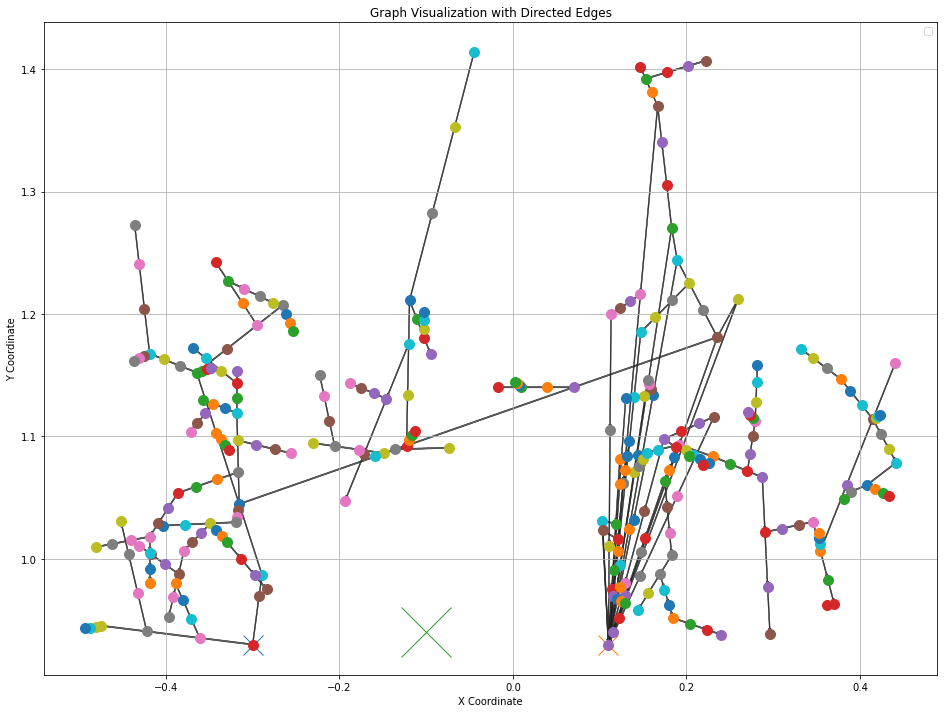

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Define the nodes with their coordinates and neighbors
# Initialize a figure
plt.figure(figsize=(16, 12))

# start cube position
xyz_start = CUBE_PLACEMENT.translation
plt.plot(xyz_start[1], xyz_start[2], 'x', markersize=20)
# end cube position
xyz_end = CUBE_PLACEMENT_TARGET.translation
plt.plot(xyz_end[1], xyz_end[2], 'x', markersize=20)
# obstacle position
xyz_end = [0.43,-0.1,0.94]
plt.plot(xyz_end[1], xyz_end[2], 'x', markersize=50)


# Plot the nodes
for node_id, node in enumerate(graph.nodes):
    x, y, z = node.cube_pose.translation
    
    plt.plot(y, z, 'o', markersize=10)  # label=f'Node {node_id}'
    #plt.text(x + 0.1, y + 0.1, f'{node_id}', fontsize=12)  # Label the node

# Plot the directed edges
for node_id, node in enumerate(graph.nodes):
    x_start, y_start, z_start = node.cube_pose.translation
    
    for neighbour_id in node.children.keys():
        x_end, y_end, z_end = graph.nodes[neighbour_id].cube_pose.translation
        
        # Draw an arrow for directed edge
        plt.arrow(
            y_start, 
            z_start, 
            y_end - y_start, 
            z_end - z_start, 
            length_includes_head=True,
            fc='gray', ec='black', linestyle='-', linewidth=0.5) # head_width=0.2,  

# Display the plot
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Graph Visualization with Directed Edges")
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


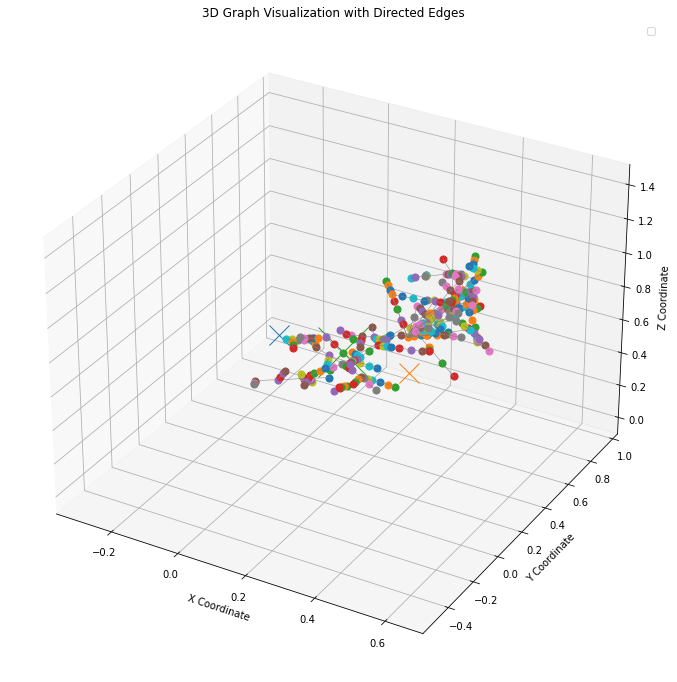

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the nodes with their coordinates and neighbors
# Initialize a figure
# Initialize a 3D figure
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')


# start cube position
xyz_start = CUBE_PLACEMENT.translation
plt.plot(xyz_start[1], xyz_start[2], 'x', markersize=20)
# end cube position
xyz_end = CUBE_PLACEMENT_TARGET.translation
plt.plot(xyz_end[1], xyz_end[2], 'x', markersize=20)
# obstacle position
xyz_end = [0.43,-0.1,0.94]
plt.plot(xyz_end[1], xyz_end[2], 'x', markersize=50)


# Plot the nodes
for node_id, node in enumerate(graph.nodes):
    x, y, z = node.cube_pose.translation
    ax.scatter(x, y, z, s=50)
    #plt.plot(y, z, 'o', markersize=10)  # label=f'Node {node_id}'
    #plt.text(x + 0.1, y + 0.1, f'{node_id}', fontsize=12)  # Label the node

# Plot the directed edges
for node_id, node in enumerate(graph.nodes):
    x_start, y_start, z_start = node.cube_pose.translation
    
    for neighbour_id in node.children.keys():
        x_end, y_end, z_end = graph.nodes[neighbour_id].cube_pose.translation
        
        ax.quiver(x_start, y_start, z_start, 
                  x_end - x_start, y_end - y_start, z_end - z_start, 
                  arrow_length_ratio=0.1, color='gray', linewidth=0.5)

# Set labels and show plot
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("3D Graph Visualization with Directed Edges")
plt.legend()
plt.show()

In [36]:
len(graph.nodes)

120

In [37]:
path, length = shortest_path(graph)

q_path = [graph.nodes[id].q for id in path]

In [38]:
displaypath(robot,q_path,dt=0.5,viz=viz)

In [39]:
import pickle as pkl
pkl.dump(q_path, open("path_control_2.pkl", "wb"))

In [183]:
path, length = shortest_path(graph)
length

0.6955278310644804

In [184]:
len(graph.nodes)

152

In [185]:
path

[0, 2, 27, 28, 29, 30, 1]

In [33]:
N=500
q0=q0
c0=CUBE_PLACEMENT
qe=qe
ce=CUBE_PLACEMENT_TARGET
n_steps_interpol=15


In [37]:
g.nodes

[<__main__.Node at 0x7f939c7db100>, <__main__.Node at 0x7f939c7d8370>]

In [35]:
start_node = Node(c0, q0)
g = Node_Graph(start_node)
end_node = Node(ce, qe)
end_node_id = g.add_node(end_node)

prev_q = q0.copy()
available_path = False
print("Creating sample path: ")


Creating sample path: 


In [38]:
# maybe make a better randomizer how this is done 
sampled_cube = generate_random_cube()

In [39]:


qt, success_grasp = computeqgrasppose(robot, q0, cube, sampled_cube, viz=None)
if success_grasp:
    closest_node_id = g.find_closest_neigbour(sampled_cube)
    closest_node = g.nodes[closest_node_id]

    qs_interpolated = compute_interpolation(robot, cube, closest_node.q, closest_node.cube, sampled_cube, n_steps=n_steps_interpol)

    if len(qs_interpolated) > 1:
        last_node_id = add_interpolations(g, qs_interpolated, closest_node_id, n_interpolations=2)

        qs_interpolated_end = compute_interpolation(robot, cube, qs_interpolated[-1][1], qs_interpolated[-1][0], ce, n_steps=n_steps_interpol)
        if len(qs_interpolated_end) > 1:

            add_interpolations(g, qs_interpolated_end, last_node_id, n_interpolations=2)

            if len(qs_interpolated_end) == n_steps_interpol+1:
                available_path = True

In [41]:
last_node_id

NameError: name 'last_node_id' is not defined

In [18]:
path = computepath(q0,qe,CUBE_PLACEMENT, CUBE_PLACEMENT_TARGET)


TypeError: computepath() missing 2 required positional arguments: 'cubeplacementq0' and 'cubeplacementqgoal'

In [ ]:
path = computepath(q0,qe,CUBE_PLACEMENT, CUBE_PLACEMENT_TARGET)

displaypath(robot,path,dt=0.5,viz=viz) #you ll probably want to lower dt


In [104]:
path, length = shortest_path(graph)
path

NameError: name 'graph' is not defined

# Part 2: Dynamics <a class="anchor" id="part2"></a>
Now that you have computed a reference path for your robot, it is time to try controlling it in a dynamics simulator. We will use pybullet for this. In theory pybullet is already installed but if not you should install it with pip:





In [1]:
!pip install pybullet

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip



This second part consists in two tasks. First, converting your path into a time-parametrised trajectory, then tracking this trajectory using the control law of your choice.

Again, you are free to use any method that you want to both tasks. 

## I. From a path to a trajectory <a class="anchor" id="TO"></a>
The first step is to parametrise your path into a time-varying trajectory that you may want to track.
Depending on your choice of a control law, this trajectory could be in the configuration space, the task space, or even something else.

I do not provide a template for this step, you are free to use any method that you see fit, so if you don't want to be bothered you can simply manually parametrise your trajectory (which is the level 0 described thereafter). However, you can score bonus marks if you go with more advanced methods. This will be described in the coming marking criteria. 


### 1. level 0: Manually set a velocity profile
Come up with a time parametrisation for your path that intuitively makes sense and move on to the control part! To do this write an interpolation function that given a certain $t$ will return a configuration in your path as well as the corresponding velocity and accelerations desired at that time. I advise to work out something that is such that the starting and final velocities are 0. 

### 2. level 1: QP programming without collision constraints (covered in next week's lecture)
What I would recommend is to use quadratic programming to solve a least square problem that fits at best the path that you computed while satisfying constraints.

The class Bezier defined in [bezier.py](https://github.com/ediadvancedrobotics/lab/blob/main/bezier.py) might prove useful.
Take a look at the [primer on Bezier curves](https://pomax.github.io/bezierinfo/) if you want more info on these methods. An example of use is provided in [control.py](https://github.com/ediadvancedrobotics/lab/blob/1d00a1c79acbcb7248df1b17cf3aaac7f8c39a8b/control.py#L47).

The motivations for using Bezier curves are multiple:

+ First, they are strictly equivalent to polynomials, which means that the trajectory you will compute will be continuous and infinitely differentiable.

+ Secondly, the initial and terminal conditions are easy to specify: the velocity at the start / end only depends on the first/last two control points, and the accelerations only on the the first/last three control points. If you choose your first three control points to be strictly equal for instance, the initial velocity and acceleration of your trajectory will be 0.

+ Thirdly, a Bezier curve lies completely in the convex hull of its control points. What this means for optimisation is that if you define linear inequality constraints on the control points of the curve, you have the guarantee that that every point on the curve satisfies these constraints. This will allow you to easily specify constraints on the derivatives

If you choose to go that way, you can decide that your optimisation variables are the control points of your Bezier curve; you can then linearly define the value of the trajectory at each time step as a linear combination of these control points and write your cost function as a function of these points.


In this approach, the idea is not to explicitely address the collision constraints. You will assume that if you track your path well enough you will avoid collisions. This is commonly done in robotics.

**Optional: the ndcurves library**

If you are interested in trajectory optimisation, you could check out [this tutorial I wrote for the ndcurves library](https://github.com/loco-3d/ndcurves/blob/master/python/test/sandbox/test.ipynb). While the API is different the concepts described are the same. **Note that I m not necessarily suggesting to use ndcurves, simply to look at the tutorials to understand the ideas and replicate this.** Still, if you want to you can decide to directly use ndcurves. It has an api a bit more complex that the simple Bezier class I provided as it is more powerful, so it is for you to decide, there is no good or bad solution here.



#### Time parametrisation:
If you follow the guidelines from the tutorial, the optimisation will give you a smooth trajectory, but by default it will have a duration of 1. You can easily add velocity constraints and include time as a variable in your problem . You could also add acceleration constraints and ignore velocities by using $t^2$ as a variable instead of $t$. We can discuss this on Piazza. You can't consider both velocity and acceleration constraints otherwise your problem will become non-linear (do you see why ?)

#### Handling grasping constraints:
If you are planning a trajectory just for the effectors then it is really easy to handle these constraints: you can just plan for the cube and then deduce the effector placements at each step.
It might be harder to do it for a configuration space trajectory, but it is not necessarily required:
I believe that if the tracked trajectory is good enough you should not need to handle the grasping constraints as accurately as this will be fixed by the control law. 
If you want to handle these constraints, there are a variety of post processes that you can choose to implement this, but though the problem becomes non-linear again... I suggest to avoid this unless it really proves useful (again I think not, or at least it was not necessary for me).



### 3. level 2: Handling collision constraints
First of all, don't go there in the first instance. Wait until you are done with the complete lab to decide whether you are interested in doing this. You can try to handle collisions in a variety of ways that we can discuss on Piazza. The straightforward approach is to write a non linear program that will handle this as we have done before. Because you have a reference motion that is collision free, you may get away with a NLP to refine the trajectory obtained when solving level 1 so as to avoid collisions.

## II. Implementing a torque control law <a class="anchor" id="control"></a>
Ok now, you have everything that you need to grasp that box and move it to its target.

Again, we are going to use pybullet to control our robot. Pybullet is a dynamics simulator which is used by roboticists to test the behaviours of their controllers before deploying them on their robots. It was originally developed for video games, and depending on your application it is not always considered as very accurate. However for manipulators it works well.

### Interaction with Pybullet 

The philosophy I propose to interact with Pybullet is implemented in the [control.py main function](https://github.com/ediadvancedrobotics/lab/blob/1d00a1c79acbcb7248df1b17cf3aaac7f8c39a8b/control.py#L61):

+ Set the initial configuration of your robot in pybullet (method setqsim)

+ At each frame:

    - get the current state of the robot in the simulator (method getpybulletstate)
    
    - work out all the computations in pinocchio
    
    - send a torque command to the simulator to update the state of the robot (method step)

Pybullet is configured here to work as a step-by-step simulation, as opposed to real time. Everytime you call the step method, the simulation integrates DT seconds of time, with DT defined in config.py.

In tools.py, I have added a method [rununtil](https://github.com/ediadvancedrobotics/lab/blob/1d00a1c79acbcb7248df1b17cf3aaac7f8c39a8b/tools.py#L102) that you can use to update the simulation at a frequency that corresponds to a realtime mode.

If you run control.py, assuming the initial state is the robot.q0 configuration, the first thing you will see is a very chaotic behaviour from the robot: indeed, as it starts in collision, the simulator will apply really high forces to compense the penetration violation.

If you initialise correctly the inital state, in the absence of torque command the robot arms will fall under the effect of gravity.

The main methods needed to work with pybullet are defined in the Simulation class defined in [setup_pybullet.py](https://github.com/ediadvancedrobotics/lab/blob/1d00a1c79acbcb7248df1b17cf3aaac7f8c39a8b/setup_pybullet.py). A few others are defined in the base class Simulation_base but I don't expect you will need them.

The helper method to load the robot in both pinocchio and pybullet environments is setupwithpybullet. If you still want to work with meshcast in parallel (for some strange reason that I can't explain I found it convenient) you can instead call setupwithpybulletandmeshcat.


### Optional task 0: Control without the cube
To test your controller, it might be a good idea to first control the motion of the effectors without grasping the cube. Generate a simple trajectory that brings the effectors above the starting position and implement the control law to achieve the motion. Regarding the gains, you definitely have the options to tune them individually for each joint (and you would have do this on the actual robot). When I programmed the lab I just used $K_p = 300$ and $K_d = 2 \sqrt(K_p)$ for all joints and it worked fine. Once you ll have verified that you obtain a satisfying behaviour, you'll be ready to move to the actual task.

### The actual task
Proceed as you wish to have the robot grasp the cube and then bring it to the target location. It does not matter to me how this is achieved in terms of the motion I see, as long as some grasping (ie the robot is holding the cube above the table for some relevant period of time) happens. You can push the cube to align it in the end if you need. 

To achieve the behaviour, you will need to apply a control law. Everything here is set for you to control the robot in torque, which I do believe is the easy way to go. If you want to try controling this using position or velocity control, this is also an option (actually the real Nextage robot is only position controlled).

The recommended way, in my opinion, is to apply inverse dynamics control to track the trajectory while applying a linear force to the cube with both hands.

This force control law should naturally cope with the alignment errors and have the effect of attracting the effectors to the cube 



In [1]:
from bezier import Bezier

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
array = np.array([[0,0], [0,1], [0,2], [3,3], [0,4]])


In [25]:
bezier = Bezier(array)

In [26]:
y = []
for i in range(1, 100):
    step = i/100
    y.append(bezier(step))

In [27]:
y

[array([0.      , 0.030001]),
 array([0.      , 0.060008]),
 array([0.      , 0.090027]),
 array([0.      , 0.120064]),
 array([0.      , 0.150125]),
 array([0.      , 0.180216]),
 array([0.      , 0.210343]),
 array([0.      , 0.240512]),
 array([0.      , 0.270729]),
 array([0.   , 0.301]),
 array([0.      , 0.331331]),
 array([0.      , 0.361728]),
 array([0.      , 0.392197]),
 array([0.      , 0.422744]),
 array([0.      , 0.453375]),
 array([0.      , 0.484096]),
 array([0.      , 0.514913]),
 array([0.      , 0.545832]),
 array([0.      , 0.576859]),
 array([0.   , 0.608]),
 array([0.      , 0.639261]),
 array([0.      , 0.670648]),
 array([0.      , 0.702167]),
 array([0.      , 0.733824]),
 array([0.      , 0.765625]),
 array([0.      , 0.797576]),
 array([0.      , 0.829683]),
 array([0.      , 0.861952]),
 array([0.      , 0.894389]),
 array([0.   , 0.927]),
 array([0.      , 0.959791]),
 array([0.      , 0.992768]),
 array([0.      , 1.025937]),
 array([0.      , 1.059304])